<a href="https://colab.research.google.com/github/abhilb/mycolab/blob/main/Replace_PReLU_with_ReLU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
print(f"Tensorflow version {tf.__version__}")

Tensorflow version 2.7.0


# Load dataset
## From Tensorflow datasets import MNIST dataset

Shuffle the data. 
Show some of the images in the dataset.

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    batch_size=32,
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

(32, 28, 28)


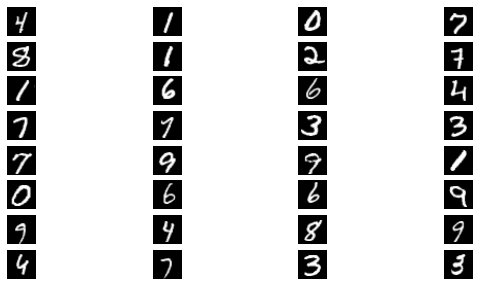

In [ ]:
for example in ds_train.take(1):
  image, label = example
  image = np.squeeze(image)
  print(image.shape)
  f, ax = plt.subplots(8, 4)
  f.set_size_inches((10, 5))
  ax = ax.flatten()
  for i in range(32):
    ax[i].imshow(image[i], cmap = "gray")
    ax[i].axis("off")
  plt.show()

In [ ]:
input_layer = tf.keras.layers.Input(shape=(28, 28, 1), batch_size=32)
x = tf.keras.layers.Conv2D(8, kernel_size=(3, 3))(input_layer)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(4, kernel_size=(3,3))(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
output_layer = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(input_layer, output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 28, 28, 1)]         0         
                                                                 
 conv2d (Conv2D)             (32, 26, 26, 8)           80        
                                                                 
 p_re_lu (PReLU)             (32, 26, 26, 8)           5408      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 13, 13, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 11, 11, 4)           292       
                                                                 
 p_re_lu_1 (PReLU)           (32, 11, 11, 4)           484       
                                                             

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [ ]:
history = model.fit(x=ds_train, batch_size=32, epochs=10, validation_data=ds_test)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1875/1875 [==============================] - 37s 19ms/step - loss: 1.2250 - sparse_categorical_accuracy: 0.8597 - val_loss: 0.1472 - val_sparse_categorical_accuracy: 0.9550
Epoch 2/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1415 - sparse_categorical_accuracy: 0.9574 - val_loss: 0.1086 - val_sparse_categorical_accuracy: 0.9672
Epoch 3/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1057 - sparse_categorical_accuracy: 0.9689 - val_loss: 0.0956 - val_sparse_categorical_accuracy: 0.9690
Epoch 4/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0912 - sparse_categorical_accuracy: 0.9736 - val_loss: 0.0949 - val_sparse_categorical_accuracy: 0.9721
Epoch 5/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0821 - sparse_categorical_accuracy: 0.9754 - val_loss: 0.0864 - val_sparse_categorical_accuracy: 0.9737
Epoch 6/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0755 - spar

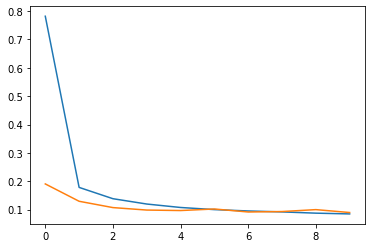

In [16]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

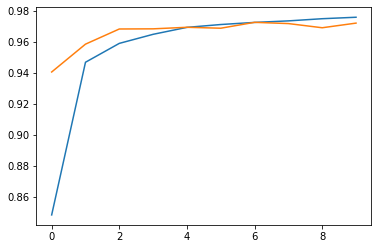

In [17]:
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.show()

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmptfo4kxxv/assets


INFO:tensorflow:Assets written to: /tmp/tmptfo4kxxv/assets
